# Logistic Regression Excercise 2

## Multi-class classification of MNIST using Logistic Regression

The multi-class scenario for logistic regression is quite similar to the binary case, except that the label $y$ is now an integer in {1, ...., K} where $K$ is the number of classes. In this excercise you will be provided with handwritten digit images. Write the code and compute the test accuracy by training a logistic regression based classifier in (i) one-vs-one, and (ii) one-vs-all setting.

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [2]:
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from utils import plot_decision_boundary, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, sigmoid, normalize
import math
import gif
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from utils.ipynb


In [43]:
np.unique(Y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [81]:
# Let's initialize our weights using uniform distribution
def weight_init_uniform_dist(X, y):
  
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = y.shape#1 #len(np.unique(y))

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

In [30]:
np.random.seed(12)

# One hot encoding of our output label vector y
def one_hot(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size), a] = 1
    return b

# Loading dataset
digits = datasets.load_digits()

# One-hot encoding of target label, Y
Y = digits.target
#Y = one_hot(Y)

# Absorbing weight b of the hyperplane
X = digits.data
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

In [28]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [31]:
X.shape,Y

((1797, 65), array([0, 1, 2, ..., 8, 9, 8]))

<Figure size 432x288 with 0 Axes>

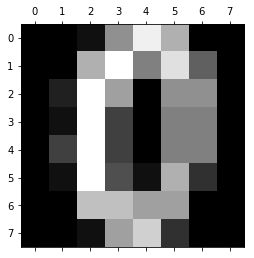

In [6]:
sns.reset_orig()

plt.gray()
plt.matshow(digits.images[10])
plt.show();

In [32]:
# Splitting dataset into train, val, and test set.
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, shuffle=True, test_size = 0.167)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.12517)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (1308, 65)
Validation dataset:  (188, 65)
Test dataset:  (301, 65)


In [33]:
# Normalizing X_train and absorbing weight b of the hyperplane
X_normalized_train = normalize(X_train[:, :64])

b_ones = np.ones((len(X_normalized_train), 1))
X_normalized_train = np.hstack((X_normalized_train, b_ones))

#### Normalize the test and validation data

In [34]:
X_normalized_test = normalize(X_test[:, :64])

b_ones = np.ones((len(X_normalized_test), 1))
X_normalized_test = np.hstack((X_normalized_test, b_ones))

X_normalized_val = normalize(X_val[:, :64])

b_ones = np.ones((len(X_normalized_val), 1))
X_normalized_val = np.hstack((X_normalized_val, b_ones))

In [35]:
X_normalized_train.shape, X_train.shape, X_normalized_test.shape, X_normalized_val.shape

((1308, 65), (1308, 65), (301, 65), (188, 65))

### Write your code below

# One vs All using Tutorial 

In [157]:
def train_one_vs_all(X_train, Y_train, base_weights, num_epochs=1000, learning_rate=0.1):

    """Method to train a multiclass classifier using one vs all technique.

    Parameters
    ------------

    X_train: ndarray (num_examples(rows) vs num_columns(columns))
    Input data on which the logistic regression model will be trained 
    to acquire optimal weights

    Y_train: ndarray (num_examples(rows) vs class_labels(columns))
    Class labels of training set

    base_weights: ndarray (num_features vs n_outputs)
    Weights used to train the network and predict on test set

    num_epochs: int
    Number of epochs you want to train the model

    learning_rate: int
    rate with which weights will be update every epoch.
    """

    n_samples, n_features = np.shape(X_train)
    n_outputs = len(np.unique(Y_train))

    history_weights = []
    weights_k_classes = []
    epoch = 1

    classes = np.unique(Y_train)

    # Training using Batch GD
    for k in classes:
        # one-vs-all binary classifier
        binary_y_train = np.where(Y_train == k, 1, 0)
        #print("binary_y_train ", binary_y_train.shape, Y_train.shape)

        weights = base_weights
        print('class...', k )
        for epoch in range(1, num_epochs+1):
            #print('epoch...', epoch )
        
    
            # Computing weighted inputs and predicting output
            w_transpose_x = np.dot(X_train, weights)
             
            y_pred = sigmoid(w_transpose_x)
            #print(y_pred)
            #print("weights, X_train , w_transpose_x,  y_pred shape" , weights.shape,X_train.shape, w_transpose_x.shape ,  y_pred.shape)
            
            # Calculating gradient and updating weights
            #print("binary_y_train , y_pred" , binary_y_train.shape , y_pred.shape)
            gradient = 1 * np.dot(X_train.T, (binary_y_train - y_pred))
            #print(gradient)
            weights += (learning_rate/n_samples) * gradient
            weights = np.round(weights, decimals=7)
            #print("gradient , weights ",gradient.shape, weights.shape)
            #weights_k_classes.append(weights)
            epoch += 1
 
        #history_weights.append(weights_k_classes)
        history_weights.append(weights)
        #weights_k_classes = []

    #print("Training complete")
    print("Training complete, history_weights", np.array(history_weights).shape)
    return history_weights

In [109]:
# Initializing weights from uniform distribution
weights = weight_init_uniform_dist(X_train, Y_train.reshape((len(Y_train)), 1))
weights.shape, #np.shape(Y_train.reshape((len(Y_train)), 1))

((65, 1),)

In [158]:
trained_weights = train_one_vs_all(X_train, Y_train.reshape((len(Y_train)), 1), weights, num_epochs=1000, learning_rate=0.01)

class... 0
class... 1
class... 2
class... 3
class... 4
class... 5
class... 6
class... 7
class... 8
class... 9
Training complete, history_weights (10, 65, 1)


In [135]:
# Compute the accuracy of training data and validation data
def predict_one_vs_all(trained_weights, X_input, Y_input):
  
    num_classes = len(np.unique(Y_input))
    scores = np.zeros((num_classes, (X_input.shape)[0]))

    for k in range(num_classes):
    
        binary_y_input = np.where(Y_input == k, 1, 0)

        w_transpose_x = np.dot(X_input, trained_weights[k])
        y_pred = sigmoid(w_transpose_x)
        y_pred = y_pred.reshape((-1,))
        scores[k, :] = y_pred

    pred_X = np.argmax(scores, axis=0)
    return pred_X

In [136]:
np.mean(pred_test_one_vs_all==Y_test)

0.10247127515148839

In [142]:
pred_train_one_vs_all = predict_one_vs_all(trained_weights, X_normalized_train, Y_train)
pred_val_one_vs_all = predict_one_vs_all(trained_weights, X_normalized_val, Y_val)
pred_test_one_vs_all = predict_one_vs_all(trained_weights, X_normalized_test, Y_test)

pred_train_one_vs_all = pred_train_one_vs_all.reshape((-1, 1))
pred_val_one_vs_all = pred_val_one_vs_all.reshape((-1, 1))
pred_test_one_vs_all = pred_test_one_vs_all.reshape((-1, 1))

print('Training dataset accuracy: %f' % (np.mean(Y_train == pred_train_one_vs_all)))
print('Validation dataset accuracy: %f' % (np.mean(Y_val == pred_val_one_vs_all)))
print('Test datast accuracy: %f' % (np.mean(Y_test == pred_test_one_vs_all)))

Training dataset accuracy: 0.100161
Validation dataset accuracy: 0.101913
Test datast accuracy: 0.102990


# Approach 2 using optimization algorithm

In [146]:
X.shape

(1797, 65)

In [147]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt

# data = sio.loadmat("digits.mat")
# x = data['X'] # the feature matrix is labeled with 'X' inside the file
# y = np.squeeze(data['y']) # the target variable vector is labeled with 'y' inside the file
#np.place(y, y == 10, 0) # replace the label 10 with 0
numExamples = X.shape[0] # 1797 examples
numFeatures = X.shape[1] # 65 features
numLabels = 10 # digits from 0 to 9

In [148]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost(theta, X, y):
    predictions = sigmoid(X @ theta)
    predictions[predictions == 1] = 0.999 # log(1)=0 causes error in division
    error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions);
    return sum(error) / len(y);

def cost_gradient(theta, X, y):
    predictions = sigmoid(X @ theta);
    return X.transpose() @ (predictions - y) / len(y)

In [149]:
X_data = np.ones(shape=(X.shape[0], X.shape[1] + 1))
X_data[:, 1:] = X

In [150]:
classifiers = np.zeros(shape=(numLabels, numFeatures + 1))
for c in range(0, numLabels):
    label = (Y == c).astype(int)
    initial_theta = np.zeros(X_data.shape[1])
    classifiers[c, :] = opt.fmin_cg(cost, initial_theta, cost_gradient, (X_data, label), disp=0)

In [151]:
classProbabilities = sigmoid(X_data @ classifiers.transpose())

In [152]:
predictions = classProbabilities.argmax(axis=1)

In [154]:
print("Training accuracy:", str(100 * np.mean(predictions == Y)) + "%")

Training accuracy: 99.88870339454647%


# One vs One approach Using Tutorial

In [166]:
# Train on the dataset
def one_vs_one_train(X_train, Y_train, weights, num_epochs=1000, learning_rate=0.1):

    """ Method to train a logistic regression model.

    Parameters
    ------------

    X_train: ndarray (num_examples(rows) vs num_columns(columns))
    Input data on which the logistic regression model will be trained 
    to acquire optimal weights

    Y_train: ndarray (num_examples(rows) vs class_labels(columns))
    Class labels of training set

    weights: ndarray (num_features vs n_output)
    Weights used to train the network and predict on test set

    num_epochs: int
    Number of epochs you want to train the model

    learning_rate: int
    rate with which weights will be update every epoch.
    """

    n_samples, n_features = np.shape(X_train)
    _, n_outputs = np.shape(Y_train)

    history_weights = []
    epoch = 1

    # Training using Batch GD
    while epoch <= num_epochs:

        # Appending previous history weights/first initialized weights
        history_weights.append(weights)

        # Computing weighted inputs and predicting output
        w_transpose_x = np.dot(X_train, weights)
        y_pred = sigmoid(w_transpose_x)
        #print('w_transpose_x , y_pred', w_transpose_x.shape , y_pred.shape)
        # Calculating gradient and updating weights
        gradient = 1 * np.dot(X_train.T, (Y_train - y_pred))
        weights += (learning_rate/n_samples) * gradient
        weights = np.round(weights, decimals=7)
        #print('gradient , weights', gradient.shape , weights.shape)
        epoch += 1

    print("Training complete")

    return history_weights

In [164]:
Y_train.shape

(1308,)

In [167]:
# Initializing weights from uniform distribution
def weight_init_uniform_dist(X, y):
  
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = np.shape(y)

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

weights = weight_init_uniform_dist(X_train, Y_train.reshape((len(Y_train)), 1))

trained_weights = one_vs_one_train(X_train, Y_train.reshape((len(Y_train)), 1), weights, num_epochs=50, learning_rate=0.1)

Training complete


In [171]:
best_weights = trained_weights[-1]

print("Evaluation results")
train_acc, _ = get_prediction(X_train, Y_train.reshape((len(Y_train)), 1), best_weights, get_acc=True, model_type='logreg', predict='yes')
val_acc, _ = get_prediction(X_val, Y_val.reshape((len(Y_val)), 1), best_weights, get_acc=True, model_type='logreg', predict='yes')
test_acc, _ = get_prediction(X_test, Y_test.reshape((len(Y_test)), 1), best_weights, get_acc=True, model_type='logreg', predict='yes')

print("Training accuracy: {:.3f}" .format(train_acc))
print("Validation accuracy: {:.3f}" .format(val_acc))
print("Test accuracy: {:.3f}" .format(test_acc))

Evaluation results
Training accuracy: 10.168
Validation accuracy: 11.702
Test accuracy: 8.970


# Using sklearn 

## One vs Rest 

In [185]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression 

OVR = OneVsRestClassifier(LogisticRegression()).fit(X_train,Y_train)
print("One vs rest accuracy: %.3f" % OVR.score(X_test, Y_test))

One vs rest accuracy: 0.957


## One vs One 

In [186]:
from sklearn.multiclass import OneVsOneClassifier
OVO = OneVsOneClassifier(LogisticRegression()).fit(X_train,Y_train)
print("One vs one accuracy: %.3f" % OVO.score(X_test, Y_test))

One vs one accuracy: 0.980


In [ ]:
# ref https://www.dummies.com/programming/big-data/data-science/using-logistic-regression-in-python-for-data-science/